# Cavity-QED in the dispersive regime with eHe

Author: K. V. Shulga (kirill-shulga@oist.jp)

In [1]:
%matplotlib inline

In [2]:
def spines(ax=None):
    if ax is None:
        ax = plt.gca()
    dict(ax.spines.items())["left"].set_position(('outward', 10))
    dict(ax.spines.items())["bottom"].set_position(('outward', 10))
    dict(ax.spines.items())["top"].set_position(('outward', 10))
    dict(ax.spines.items())["right"].set_position(('outward', 10))
    
def annotate_distance(ax, text, point1, point2, linestyle, fontsize, textoffset = (0.1,0)):
    ax.annotate('', point1, point2, \
            arrowprops={'arrowstyle':'<->', 'linestyle':linestyle, "facecolor":"black"}, fontsize=fontsize);
    ax.annotate(text, point1, (0.5*(point1[0]+point2[0])+textoffset[0], 0.5*(point1[1]+point2[1])+textoffset[1]),
                fontsize=fontsize)

In [3]:
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import *
from qutip import *

from IPython.display import HTML
from matplotlib import animation
from qutip import *
from scipy.constants import e, h, Boltzmann, hbar, k, m_e, epsilon_0, mu_0
from scipy.sparse import csr_matrix
from scipy.sparse import spdiags, diags
from scipy.fft import dct, idct, dst, idst
import scipy.linalg as scl

from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

In [4]:
from ipywidgets import IntProgress
from IPython.display import display
import time

# Introduction

Free electrons can be trapped near the surface of liquid helium (at a distance of about 10 nm) due to a weak attraction to the liquid (polarizability of helium atoms) and a repulsion from the helium atoms (Pauli exclusion principle). The basic quantum-mechanical Hamiltonian for a single electron above liquid helium is given by

### $H = \frac{\textbf{P}^2}{2m_e} + V(\textbf{R})$,

where $m_e$ is the bare electron mass. Assuming an infinitely extended flat surface of liquid, the potential energy of an electron can be written as

### $V(\textbf{R}) = V_0 \Theta(-z) - \frac{\Lambda}{z}\Theta(z)$.

Here $z$ is the electron coordinate in the direction perpendicular to the surface, $V_0 \approx 1$ eV is the height of the repulsive potential barrier at $z=0$, and $\Theta(z)$ is the Heaviside (step) function.

### Problem parameters

Physical constants definition (in SI units)

In [114]:
from scipy.constants import e, h, Boltzmann, hbar, k, m_e, epsilon_0, mu_0, c

In [6]:
hb   = hbar                            # Plank constant [Js], or 4.136e-15 [eV s]
qe   = e                               # elementary charge [C]
ep4  = 1.0572                          # the relative permittivity of 4He
ep32 = 1.0462                          # the relative permittivity of 3He
ep3  = 1.042                           # the relative permittivity of 3He (in Monakha's book)
ep0  = epsilon_0                       # the electric constant (vacuum permittivity) [C^2 Nm^-2]
mu0  = mu_0                            # the magnetic constant [Tm/A]
me   = m_e                             # electron mass [kg] or 0.5109 [MeV]
mb   = 9.2740100783e-24                # Bohr Magneton [J T^-1]
kB   = Boltzmann

The term $\frac{\Lambda}{z}\Theta(z)$ describes attraction of an electron to a weak image charge inside the liquid, where $\Lambda$ is determined by the dielectric constant of liquid helium ε as

### $\Lambda = \frac{e^2}{16\pi\varepsilon_0}\frac{\varepsilon -1}{\varepsilon+1}$.

In [7]:
l4  = qe**2 / 4 * ( ep4 - 1) / ( ep4 + 1) / 4 / ep0 / pi      # the Coulomb constant for 4He
#l3  = qe**2 / 4 * ( ep3 - 1) / ( ep3 + 1) / 4 / ep0 / pi     # the Coulomb constant for 3He (Monakha's book)
#l32 = qe**2 / 4 * (ep32 - 1) / (ep32 + 1) / 4 / ep0 / pi     # the Coulomb constant for 3He

Define the energy and length scale we choose for $^4$He:

In [8]:
#The whole system uses energy scale of Rydberg_Constant, and length scale of Borh_Radius
    
R  = me * l4**2/(2 * hb**2)                         # the Rydberg constant for image charge in 4He
rB = hb**2/(l4 * me)                                # the effective Borh radius

The main Hamiltonian can be separated into two parts corresponding to the orbital motion of an electron in the direction perpendicular to the surface ($H_z$) and parallel to the surface. In z-direction, the electron motion is quantized into the surface bound states which are the eigenstates of the Hamiltonian

### $H_z = \frac{p_z^2}{2m_e} + V_0 \Theta(-z) - \frac{\Lambda}{z}\Theta(z) $.

The energy spectrum of this motion can be easily found by making an assumption of a rigid-wall repulsive barrier, that is $V_0 \rightarrow +\infty$. In this case it coincides with the energy spectrum of an electron in the hydrogen atom $−R_e/n^2,~~ n=1,2,..$, where $R_e = m_e\Lambda^2/(2 ̄\hbar^2)$ is the effective Rydberg constant. This constant is about 63 meV (36 meV) for an electron above liquid $^4$He ($^3$He). An electron in the ground Rydberg state localizes above the surface of liquid at an average distance $〈z〉 \approx r_B$, where $r_B = \hbar^2/(\Lambda m_e)$ is the effective Bohr radius. This radius is about 7.8 nm (10.3 nm) for an electron above liquid $^4$He ($^3$He).

There is always a static electric field $E_⊥$ applied perpendicular to the liquid surface.  The dc-Stark shift induced by this field provides a way to tune energy difference between the Rydberg states for their spectroscopic studies. It adds an additional term $eE_⊥z$ to the Hamiltonian and changes its eigenenergy spectrum.

In [9]:
Ez = 3.5*5*100                       # perpendicular Electric field [V/cm*100]
Ex = 0.0                             # lateral Electric field [V/cm*100]

We also introduce a vertical $B_z$ and horizontal $B_y$ component of the tilted magnetic field. 
The new (diamagnetic) term appears in this Hamiltonian because of the presence of a parallel component of the magnetic field.

### $H_q = \frac{m_e\omega_y^2z^2}{2}$,

where we define $\omega_y=eB_y/m_e$. 

When an electron are subject to a static magnetic field $B_z$ applied perpendicular to the surface, the electron in-plane motion is quantized into the states with an equidistant energy spectrum $\hbar\omega_c (l+1/2)$ (the Landau levels), where $\omega_c=eB_z/m_e$ is the cyclotron frequency and $l=0,1,..$ is the quantum number. 

In [10]:
By = 0.03                        # horizontal magnetic field B_y field [T]
Bz = 0.208                       # vertical magnetic field B_z field [T]
wy = qe*By/me                    # fixed value of the \Omega_y
wc = qe*Bz/me                    # fixed value of the cyclotron frequency  
#lB = sqrt(hb/(qe*Bz))           # parameter in the interaction Hamiltonian

In [11]:
print('Landau frequency:', wc/(2*pi)/10**9, 'GHz')

Landau frequency: 5.822437893445271 GHz


some intermediate constants from which the Hamiltonian will be composed

In [12]:
c1 = l4/(rB*R)              # the coulomb interaction term
c2 = qe*Ez*rB/R             # additional dc-Stark term in z direction
c3 = me*wy**2*rB**2/R       # the quadratic diamagnetic term in z direction
c4 = qe*Ex*rB/R             # additional dc-Stark term in x direction             
c5 = me*wc**2*rB**2/R       # the quadratic diamagnetic term in z direction       

In [13]:
def Lap(N, h):   
    #Laplace operator
    operator = 1./(h*h)*(diag(ones(N-1),-1) - 2*diag(ones(N),0) + diag(ones(N-1),1))
    return operator

Then we construct the Hamiltonian $𝐻_𝑧$ and solve it by finding its eigenvalues

In [14]:
nsolz = 2                                # The number of energy levels we are interested in           
nz = 5000                                # Number of vertical axis sampling steps
az = 500                                 # Maximum altitude above helium level [nm]
dz = az/(nz+1)                           # Vertical axis step
zgrid = asarray(range(1,nz+1,1)) * dz    # Discretization of the vertical axis

constructing the Vertical Hamiltonian

In [15]:
Vz  = -c1/zgrid + c2*zgrid + c3*zgrid**2/2.0  # coulomb interaction term + linear potential term + quadratic diamagnetic term
#Vz  = c2*zgrid/2 + c3*zgrid**2/2.0
lap = Lap(nz,dz)                              # the momentum term
Hz  = -lap + diag(Vz)                         # the total z Hamiltonian

In [16]:
Ez_eigh, psizT = linalg.eigh(Hz)              # the eigenvalues and eigenvectors
psiz = transpose(psizT)                       # transpose of psiT to the wavefunction vectors

In [17]:
Ez_eigh[1]

-0.13756896524249224

In [18]:
print('Rydberg frequency:', (Ez_eigh[1]-Ez_eigh[0]) * (R/h/1e9), 'GHz')
print('Anharmonicity:', (Ez_eigh[2]-Ez_eigh[1]-((Ez_eigh[1]-Ez_eigh[0]))) * (R/h/1e9), 'GHz')

Rydberg frequency: 131.90270124363016 GHz
Anharmonicity: -93.18248152832406 GHz


In [19]:
for i in range(20):
    print((Ez_eigh[i+1]-Ez_eigh[i]) * (R/h/1e9))

131.90270124363016
38.720219715306115
24.35524496704369
19.203558902775345
16.523112634187672
14.842123051568908
13.667668571568406
12.788269863371136
12.097600490084309
11.53600106568644
11.067199238673018
10.66775096208211
10.32175716541726
10.018009471524842
9.748350370775732
9.506682375769135
9.28834355911063
9.089699695565084
8.907869589550444
8.740535115196977


Plotting wave functions of electrons at different Rydberg levels

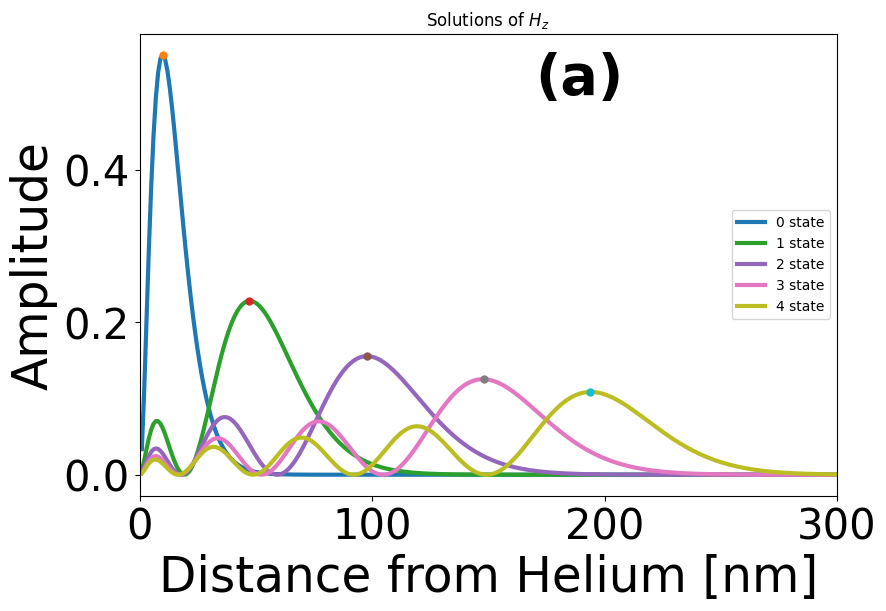

In [20]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(9, 6))

for i in range(nsolz+3):
    #p = axes.plot(zgrid*10, psiz[i]**2/dz,label="$f_{}$ ={:>8.3f} GHz".format(i,(Ez_eigh[i]-Ez_eigh[0]) * (R/h/1e9)), linewidth=3.0)
    p = axes.plot(zgrid*10, psiz[i]**2/dz,label="{:>1.0f} state".format( i), linewidth=3.0)
    plt.title("Solutions of $H_z$")
    p = axes.plot(zgrid[argmax(psiz[i]**2/dz)]*10, max(psiz[i]**2/dz), marker="o", markersize = 5)
    
    #plt.text(zgrid[argmax(psiz[i]**2/dz)], max(psiz[i]**2/dz), 'b', fontsize=24,transform=axes.transAxes)

plt.legend(loc = 'center right')
axes.set_ylabel('Amplitude', fontsize=35)
axes.set_xlabel('Distance from Helium [nm]', fontsize=35)   #[$\AA$]
axes.set_xlim(0,300)
#plt.show()

matplotlib.pyplot.text(170, 0.52, '(a)', fontsize=40, weight="black",  verticalalignment='center')

axes.tick_params(axis='x', labelsize=30)
axes.tick_params(axis='y', labelsize=30)

#plt.gcf().set_size_inches(9,6)
#plt.savefig("C:/Users/Kirill/Desktop/SolutionsHz.pdf", bbox_inches="tight")

In [21]:
for i in range(nsolz+20):
    print(zgrid[argmax(psiz[i]**2/dz)]*10)

9.998000399920016
46.99060187962408
97.98040391921616
147.97040591881623
193.96120775844832
236.9526094781044
276.94461107778443
314.9370125974805
350.92981403719256
385.92281543691263
418.91621675664874
450.9098180363927
480.9038192361528
510.8978204359129
539.8920215956808
568.886222755449
595.8808238352331
622.875424915017
649.870025994801
674.8650269946012
700.8598280343932
725.8548290341932


In [22]:
for i in range(nsolz+20):
    print(zgrid[argmax(psiz[i+1]**2/dz)]*10-zgrid[argmax(psiz[i]**2/dz)]*10)

36.992601479704064
50.98980203959208
49.99000199960007
45.9908018396321
42.99140171965607
39.99200159968004
37.992401519696045
35.99280143971208
34.99300139972007
32.99340131973611
31.993601279743984
29.994001199760078
29.994001199760078
28.994201159767954
28.99420115976818
26.994601079784047
26.994601079783934
26.994601079784047
24.99500099980014
25.994801039792037
24.995000999800027
23.995200959808017


For future calculations, it will be more convenient for us to think of only the two lowest Rydberg energy levels. 

Therefore lets construct a transition matrix $Z_{nm}$ for them.

In [21]:
zz = concatenate(([0.], zgrid, [az]))

Enz = asarray(Ez_eigh[range(nz)])

znm = []
for i in range(nsolz):
    if psiz[i][nz-10] < 0:
             psiz[i] =- psiz[i]
    for j in range(nsolz):
        if psiz[j][nz-10] < 0:
             psiz[j] =- psiz[j]
            
        znm.append(sum(psiz[i]*psiz[j]*zgrid))

In [22]:
znm = reshape(znm,(nsolz,nsolz))
print(znm)
#hinton(znm)

[[1.47375613 0.59843594]
 [0.59843594 5.17588316]]


The vertical and in-plane motions of an electron are uncoupled, and the full Hamiltonian describing the electron’s orbital motion can be represented as

### $H_0 = H_z + \frac{(\textbf{p}+e\textbf{A})^2}{2m_e} = H_z + \hbar\omega_c(a^{\dagger} a+\frac{1}{2})$,

where $\textbf{A}$ is the vector potential. We define the operator $a = (\sqrt{2}l_B)^{−1}(p_xl^2_B/\hbar-i(x+x_0))$, where $x_0=p_y/(eB_z)$ and $ l_B=\sqrt{\hbar/eB_z}$.  The operator $a$ satisfies the commutation relation $[a,a^{\dagger}] = 1$.

In [23]:
nsolx = 25                                 # The number of Landau energy levels we are interested in 
nx = 3000                                  # Number of horizontal axis sampling steps
ax = 150                                   # Maximum horizontal width [nm]

dx = ax/(nx+1)                                        # Horizontal axis step
xgrid = ax*(asarray(range(1,nx+1,1))/(nx+1.0) - 0.5)  # Discretization of the horizontal axis

constructing the horizontal Hamiltonian

In [24]:
Vx  = c4*xgrid+c5*xgrid**2/2.0
lap = Lap(nx,dx)
Hx  = -lap + diag(Vx) 

Ex_eign, psixT = linalg.eigh(Hx)     # the eigenvalues and eigenvectors
psix = transpose(psixT)         # transpose of psiT to the wavefunction vectors

In [25]:
print('Landau frequency:', (Ex_eign[1]-Ex_eign[0]) * (R/h/1e9), 'GHz')
#print('Anharmonicity:', (Ex[2]-Ex[1]-((Ex[1]-Ex[0]))) * (R/h/1e9), 'GHz')
#for i in range(nsolx):
#    print(((Ex[1]-Ex[0])-(Ex[i+1]-Ex[i])) * (R/h/1e9))

Landau frequency: 5.822404593093202 GHz


In [26]:
for i_id, i_value in enumerate(Ex_eign):
    print ((Ex_eign[i_id+1]-Ex_eign[i_id]) * (R/h/1e9))

5.822404593093202
5.822371292521782
5.822337991668543
5.822304690508613
5.822271389075616
5.8222380873461965
5.822204785344512
5.822171483054273
5.8221381804717325
5.822104877613667
5.822071574453998
5.822038271017039
5.822004967303936
5.821971663290617
5.821938358997951
5.821905054419576
5.821871749550337
5.82183844440312
5.821805138967282
5.82177183324531
5.821738527231011
5.821705220940498
5.821671914361416
5.821638607492583
5.8216053003437604
5.821571992909916
5.821538685213445
5.821505377350252
5.821472069762831
5.8214387643430525
5.821405469059644
5.821372215075864
5.821339118279763
5.821306585765559
5.821275968734439
5.821251499177591
5.821245663990452
5.821293093690338
5.821483778725279
5.822035879396695
5.823439790264903
5.826708884334699
5.833745038716665
5.847735334622765
5.873334962088428
5.916261146915179
5.982054528568028
6.0742993217545855
6.193204779013155
6.335447794604934
6.495364880046898
6.666707039219562
6.844035253353503
7.023351758671433
7.202097938589677
7.37884

130.53442180746478
130.56219217518208
130.58981946063318
130.6173036334753
130.64464466360064
130.67184252108208
130.69889717604678
130.7258085988748
130.75257676012706
130.77920163041858
130.80568318059935
130.8320213815555
130.85821620455275
130.88426762083859
130.91017560182325
130.93594011920618
130.96156114463247
130.98703865010876
131.01237260767778
131.03756298961716
131.062609768295
131.0875129162239
131.11227240618751
131.1368882110057
131.16136030371518
131.18568865751524
131.20987324569566
131.2339140418533
131.2578110195309
131.28156415252417
131.30517341493604
131.32863878081525
131.3519602244455
131.37513772029106
131.3981712428887
131.42106076708228
131.44380626773375
131.46640771994
131.4888650989064
131.51117838010927
131.53334753898895
131.55537255127481
131.57725339285895
131.59899003974186
131.62058246814084
131.64203065434558
131.6633345748445
131.68449420637904
131.70550952563644
131.72638050968342
131.74710713560478
131.76768938068415
131.78812722240386
131.80842

IndexError: index 3000 is out of bounds for axis 0 with size 3000

Plotting wave functions of electrons at different Landau levels

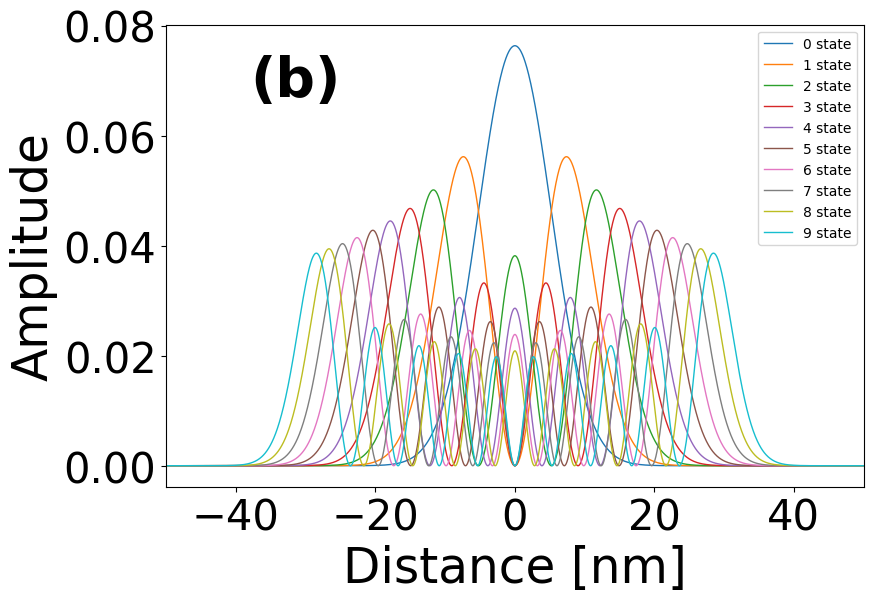

In [33]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(9, 6))

for i in range(nsolx-15):
    #p = plot(xgrid,psix[i]**2/dx,label="$E_{}$={:>8.3f} GHz".format(i,(Ex_eign[i]-Ex_eign[0]) * (R/h/1e9)), linewidth=3.0)
    p = axes.plot(xgrid,psix[i]**2/dx,label="{:>1.0f} state".format(i), linewidth=1.0)
    #plt.title("Solutions of $H_x$")

plt.legend(loc = 'upper right')
axes.set_ylabel('Amplitude', fontsize=35)
axes.set_xlabel('Distance [nm]', fontsize=35)   #[$\AA$]
axes.set_xlim(-ax/2,ax/2)
axes.set_xlim(-50,50)
#plt.show()

matplotlib.pyplot.text(-38, 0.07, '(b)', fontsize=40, weight="black",  verticalalignment='center')

axes.tick_params(axis='x', labelsize=30)
axes.tick_params(axis='y', labelsize=30)

#plt.gcf().set_size_inches(9,6)
#plt.savefig("C:/Users/Kirill/Desktop/SolutionsHx.pdf", bbox_inches="tight")

In [41]:
Enx = asarray(Ex_eign[range(nx)])

xnm = []
for i in range(nsolx):
    if psix[i][nx-10] < 0:
             psix[i]=- psix[i]
    for j in range(nsolx):
        if psix[j][nx-10] < 0:
             psix[j]=- psix[j]
            
        xnm.append(sum(psix[i]*psix[j]*xgrid))
xnm = reshape(xnm,(nsolx,nsolx))
#print(xnm)
#hinton(xnm)

Each electron eigenstate is the product of a Rydberg state $|n〉$ of vertical motion corresponding to the eigenenergy $E_n$ of the Hamiltonian $H_z$ and a state $|l〉$ of in-plane cyclotron motion, where $a^{\dagger}a|l〉=l|l〉$. 

When an additional component of static magnetic field is applied parallel to the liquid surface, in other words when the magnetic field $B$ is tilted with respect to z-axis, the vertical and in-plane motions are coupled. The electron full Hamiltonian becomes

### $H = (H_z + \frac{m_e\omega_y^2z^2}{2}) + \hbar\omega_c(a^{\dagger} a+\frac{1}{2}) + \frac{\hbar \omega_y}{\sqrt{2}l_B}(a^{\dagger}+a)z$ 


Now, let's construct the Full Hamiltonian with the interaction term. 
Each electron eigenstate is the product of a Rydberg state $|n〉$ of vertical motion corresponding to the eigenenergy $E_n$ of the Hamiltonian $H_z$ and a state $|l〉$ of in-plane cyclotron motion, where $a^{\dagger}a|l〉=l|l〉$. 

In [59]:
#wz   = wc/(R/hb)                                            # cavity frequency
#g    = sqrt(wc*me/(2*hb))*wy*rB/wr                          # coupling constant 
#a    = tensor(destroy(nsolx), qeye(nsolz))                  # annihilation operator of the resonator
#sm   = tensor(qeye(nsolx), destroy(nsolz))                  # \sigma_- operator of the qubit
#idm  = tensor(qeye(nsolx), qeye(nsolz))                     # identity operator
#zop  = tensor(qeye(nsolx), Qobj(znm))                       # Z_{nm} operator
#Hzop = tensor(qeye(nsolx), Qobj(diag(Enz[0:nsolz])))        # vertical Hamiltonian
#Hxop = tensor(Qobj(diag(Enx[0:nsolx])), qeye(nsolz))        # horizontal Hamiltonian
#H0   = H0 = wz * a.dag() * a + Hzop                         # decoupled Hamiltonian 
#Hint = g * (a.dag() + a) * zop                                # interaction operator H_int
#na   = sm.dag() * sm                                        # number of exitation in atom
#nc   = a.dag()  * a  

In [60]:
wz   = wc/2/pi/1e9                                          # cavity frequency in [GHz]
g    = sqrt(me*wc*(wy)**2/(2 * hb)) * rB /(2*pi*1e9)        # coupling constant in [GHz]

a    = tensor(destroy(nsolx), qeye(nsolz))                  # annihilation operator of the resonator
sm   = tensor(qeye(nsolx), destroy(nsolz))                  # \sigma_- operator of the qubit
sx   = tensor(qeye(nsolx), sigmax())                        # \sigma_x operator of the qubit (only for 2 levels)
idm  = tensor(qeye(nsolx), qeye(nsolz))                     # identity operator
zop  = tensor(qeye(nsolx), Qobj(znm))                       # Z_{nm} operator
Hzop = tensor(qeye(nsolx), Qobj(diag(Enz[0:nsolz])))        # vertical Hamiltonian
Hxop = tensor(Qobj(diag(Enx[0:nsolx])), qeye(nsolz))        # horizontal Hamiltonian

H0   = wz * a.dag() * a + Hzop * (R/h/1e9)                  # decoupled Hamiltonian in [GHz] units

Hint = g * (a.dag() + a) * zop                              # interaction operator H_int in [GHz] units

na   = sm.dag() * sm                                        # number of exitation in atom
nc   = a.dag()  * a                                         # number of exitation in cavity

Finaly construct the full Hamiltonian for the electron on  helium

In [61]:
H = H0 + Hint               # Full Hamiltonian
#hinton(H)

In [62]:
Eigen_H = H.eigenstates()[0]

# Now let's explore the time evolution of the different parameters of our system

In [63]:
na =  a.dag() * a            # number of excitations in the qubit
nc = sm.dag() * sm           # number of excitations in the resonator 
xa = a.dag()  + a            # x quadrature of the qubit
pa = a.dag()  - a            # p quadrature of the qubit
xc = sm.dag() + sm           # x quadrature of the resonator
pc = sm.dag() - sm           # p quadrature of the resonator

In [64]:
#psi0 = tensor(coherent(nsolx, sqrt(4)), basis(nsolz,1))                         # Rydberg excited state, Landau coherent
#psi0 = tensor(coherent(nsolx, sqrt(4)), basis(nsolz,0))                         # Rydberg ground state, Landau coherent
psi0  = tensor(coherent(nsolx, sqrt(4)), (basis(nsolz,0)+basis(nsolz,1)).unit()) # Rydberg superposition state, Landau coherent
tlist = linspace(0, 40000, 80000)                                                # time period

In [65]:
res = mesolve(H, psi0, tlist, [], [])#, options=Odeoptions(nsteps=2000))

### Excitation numbers

We can see that the systems do not exchange any energy without interaction ($B_y = 0$), because they are off resonance with each other.

In [66]:
na_list = expect(na, res.states)
nc_list = expect(nc, res.states)

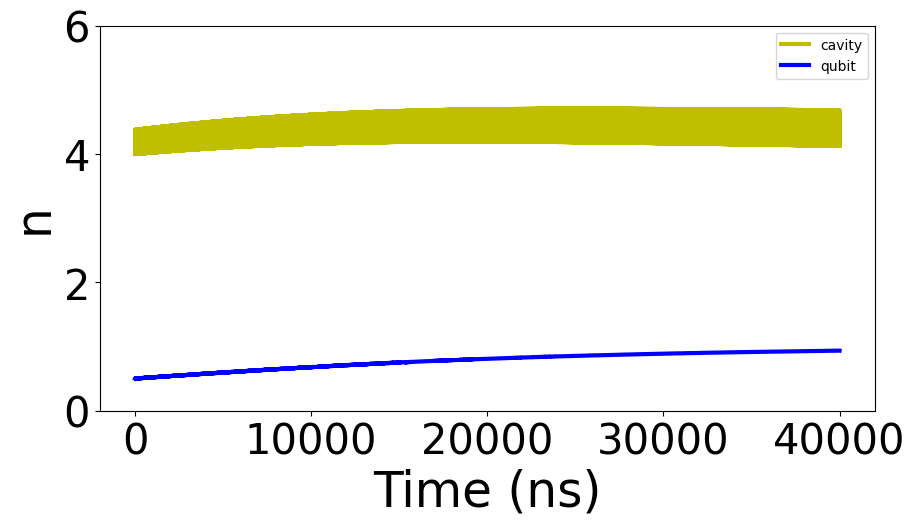

In [67]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(10, 5))

p = axes.plot(tlist, na_list, 'y', linewidth=3, label="cavity")
p = axes.plot(tlist, nc_list, 'b', linewidth=3, label="qubit")

plt.legend()  #loc = 'upper right')
axes.set_ylabel('n', fontsize=35)
axes.set_xlabel('Time (ns)', fontsize=35)  
axes.set_ylim(0, 6)

#matplotlib.pyplot.text(-38, 0.07, '(b)', fontsize=40, weight="black",  verticalalignment='center')

axes.tick_params(axis='x', labelsize=30)
axes.tick_params(axis='y', labelsize=30)

#plt.gcf().set_size_inches(12,4)
#plt.savefig("C:/Users/Kirill/Desktop/excitation_number_B_y=0.0.pdf", bbox_inches="tight")

In [68]:
#na_list_0_00 = na_list
#na_list_0_01 = na_list
#na_list_0_03 = na_list
#na_list_0_07 = na_list

In [69]:
#tlist = linspace(0, 100, 4000)   

#hfont = {'fontname':'Arial'}
#fig, axes = plt.subplots(1,1,figsize=(12, 4))

#p = axes.plot(tlist, na_list_0_00, 'r', linewidth=3, label="$B_y = 0.00$ T")
#p = axes.plot(tlist, na_list_0_01, 'b', linewidth=3, label="$B_y = 0.01$ T")
#p = axes.plot(tlist, na_list_0_03, 'y', linewidth=3, label="$B_y = 0.03$ T")
#p = axes.plot(tlist, na_list_0_07, 'c', linewidth=3, label="$B_y = 0.07$ T")

#plt.legend()  #loc = 'upper right')
#axes.set_ylabel('n', fontsize=35)
#axes.set_xlabel('Time (ns)', fontsize=35)  
#axes.set_ylim(3.8, 5.1)
#axes.set_xlim(0, 50)

#matplotlib.pyplot.text(-38, 0.07, '(b)', fontsize=40, weight="black",  verticalalignment='center')

#axes.tick_params(axis='x', labelsize=30)
#axes.tick_params(axis='y', labelsize=30)

#plt.gcf().set_size_inches(12,4)
#plt.savefig("C:/Users/Kirill/Desktop/cavity_excitation_number.pdf", bbox_inches="tight")

### Resonator quadrature
However, the quadratures of the resonator are oscillating rapidly.

In [70]:
xc_list = expect(xc, res.states)

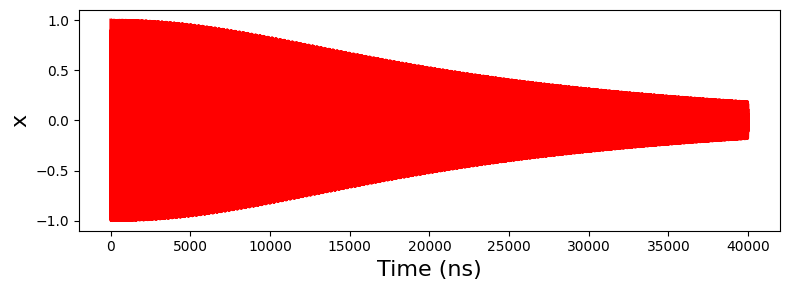

In [71]:
hfont = {'fontname':'Arial'}
fig, ax = plt.subplots(1,1,sharex=True,figsize=(8,3))

ax.plot(tlist, xc_list, 'r', linewidth=2)
ax.set_ylabel("x", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
fig.tight_layout()

Correlation function for the resonator $\left<a^\dagger(t) a(t+\tau)\right>$.

In [72]:
corr_vec = correlation_2op_2t(H, psi0, None, tlist, [], a.dag(), a, options=Odeoptions(nsteps=2000))

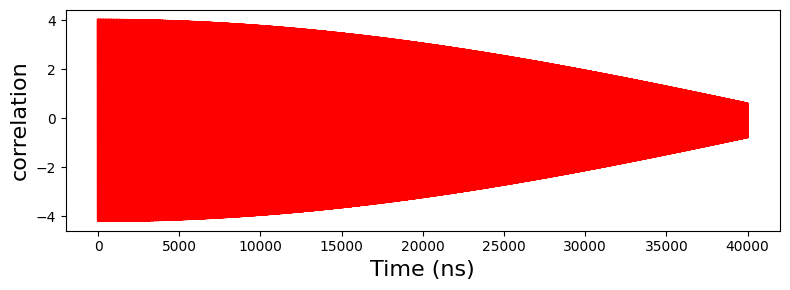

In [73]:
hfont = {'fontname':'Arial'}
fig, ax = plt.subplots(1,1,sharex=True,figsize=(8,3))

ax.plot(tlist, real(corr_vec), 'r', linewidth=2)
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)

#ax.set_xlim(0,50)
fig.tight_layout()

Spectrum of the resonator

In [74]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

(5.672404593093201, 5.972404593093202)

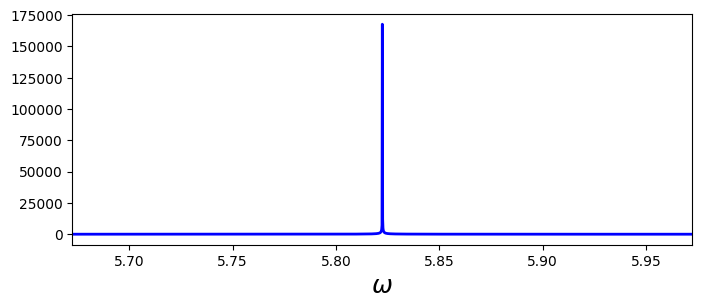

In [75]:
wr = (Ex_eign[1]-Ex_eign[0]) * (R/h)/1e9
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(w, abs(S),'b', linewidth=2)
ax.set_xlabel(r'$\omega$', fontsize=18)

#plt.plot(wr, 3000, marker = "o", markersize = 5)
#plt.plot(wr + 0.027, 3000, marker = "o", markersize = 5)    # B_y = 0.01
#plt.plot(wr + 0.095, 5000, marker = "o", markersize = 5)    # B_y = 0.07


ax.set_xlim(wr-0.15, wr+0.15)

In [ ]:
x = electrocardiogram()[2000:4000]                              #[43315.78743735  9315.49910208]  - superposition
peaks, _ = find_peaks(abs(S), height=2000)                      #  - excited state
print(abs(S)[peaks])

## Correlation function of the qubit

In [410]:
corr_vec = correlation_2op_2t(H, psi0, None, tlist, [], sx, sx, options=Odeoptions(nsteps=10000))

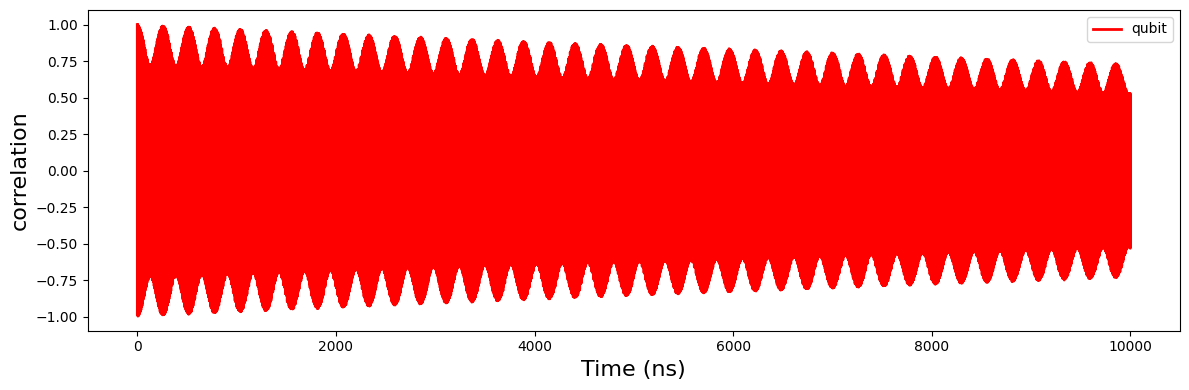

In [411]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, real(corr_vec), 'r', linewidth=2, label="qubit")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
#ax.set_xlim(0,50)
fig.tight_layout()

## Spectrum of the qubit

The spectrum of the qubit has an interesting structure: from it one can see the photon distribution in the resonator mode!

In [412]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

(1.037, 1.05)

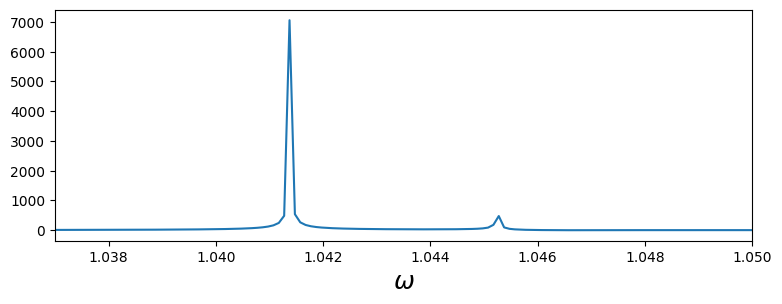

In [420]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(w / (2 * pi), abs(S))
ax.set_xlabel(r'$\omega$', fontsize=18)
ax.set_xlim(1.037, 1.05)

It's a bit clearer if we shift the spectrum and scale it with $2\chi$

 Compare to the cavity fock state distribution:

In [76]:
rho_cavity = ptrace(res.states[-1], 0)

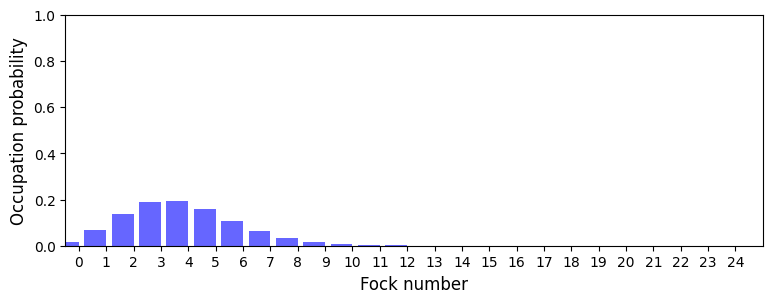

In [77]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, nsolx)-.4, real(rho_cavity.diag()), color="blue", alpha=0.6)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, nsolx)
axes.set_xticks(arange(0, nsolx))
axes.set_xlabel('Fock number', fontsize=12)
axes.set_ylabel('Occupation probability', fontsize=12);

And if we look at the cavity wigner function we can see that after interacting dispersively with the qubit, the cavity is no longer in a coherent state, but in a superposition of coherent states.

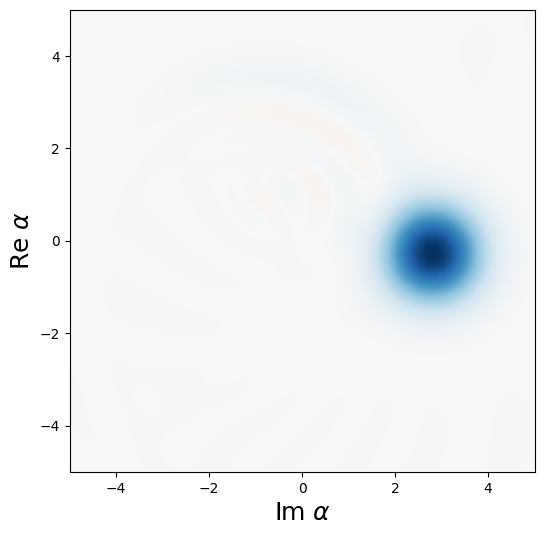

In [78]:
fig, axes = plt.subplots(1, 1, figsize=(6,6))

xvec = linspace(-5,5,200)
W = wigner(rho_cavity, xvec, xvec)
wlim = abs(W).max()

axes.contourf(xvec, xvec, W, 1000, norm=mpl.colors.Normalize(-wlim,wlim), cmap=plt.get_cmap('RdBu'))
axes.set_xlabel(r'Im $\alpha$', fontsize=18)
axes.set_ylabel(r'Re $\alpha$', fontsize=18);

# 3D plotting, sweeping B_y and B_z

Let's sweep $B_z$ and $B_y$ to show different regions of $2\chi$ in 3D

In [92]:
def Landau_split(By, Bz, Ez, nsolz, nz, az, nsolx, nx, ax, tlist, psi0):
    
    wy = qe*By/me                    # fixed value of the \Omega_y
    wc = qe*Bz/me                    # fixed value of the cyclotron frequency  
    
    c1 = l4/(rB*R)              # the coulomb interaction term
    c2 = qe*Ez*rB/R             # additional dc-Stark term in z direction
    c3 = me*wy**2*rB**2/R       # the quadratic diamagnetic term in z direction
    c4 = qe*Ex*rB/R             # additional dc-Stark term in x direction             
    c5 = me*wc**2*rB**2/R       # the quadratic diamagnetic term in z direction  
    
    dz = az/(nz+1)                           # Vertical axis step
    zgrid = asarray(range(1,nz+1,1)) * dz    # Discretization of the vertical axis
    
    Vz  = -c1/zgrid + c2*zgrid + c3*zgrid**2/2.0  # coulomb interaction term + linear potential term + quadratic diamagnetic term
    lap = Lap(nz,dz)                              # the momentum term
    Hz  = -lap + diag(Vz)                         # the total z Hamiltonian
    
    Ez_eigh, psizT = linalg.eigh(Hz)              # the eigenvalues and eigenvectors
    psiz = transpose(psizT)                       # transpose of psiT to the wavefunction vectors
    
    zz = concatenate(([0.], zgrid, [az]))
    Enz = asarray(Ez_eigh[range(nz)])

    znm = []
    for i in range(nsolz):
        if psiz[i][nz-10] < 0:
                 psiz[i] =- psiz[i]
        for j in range(nsolz):
            if psiz[j][nz-10] < 0:
                 psiz[j] =- psiz[j]
            
            znm.append(sum(psiz[i]*psiz[j]*zgrid))
            
    znm = reshape(znm,(nsolz,nsolz))
    
    #-------------------------------------------------------

    dx = ax/(nx+1)                                        # Horizontal axis step
    xgrid = ax*(asarray(range(1,nx+1,1))/(nx+1.0) - 0.5)  # Discretization of the horizontal axis
    
    Vx  = c4*xgrid+c5*xgrid**2/2.0
    lap = Lap(nx,dx)
    Hx  = -lap + diag(Vx) 

    Ex_eign, psixT = linalg.eigh(Hx)     # the eigenvalues and eigenvectors
    psix = transpose(psixT)         # transpose of psiT to the wavefunction vectors
    
    Enx = asarray(Ex_eign[range(nx)])

    xnm = []
    for i in range(nsolx):
        if psix[i][nx-10] < 0:
                 psix[i]=- psix[i]
        for j in range(nsolx):
            if psix[j][nx-10] < 0:
                 psix[j]=- psix[j]
            
            xnm.append(sum(psix[i]*psix[j]*xgrid))
    xnm = reshape(xnm,(nsolx,nsolx))
    
    #-------------------------------------------------------------------------
    
    wz   = wc/2/pi/1e9                                          # cavity frequency in [GHz]
    g    = sqrt(me*wc*(wy)**2/(2 * hb)) * rB /(2*pi*1e9)        # coupling constant in [GHz]

    a    = tensor(destroy(nsolx), qeye(nsolz))                  # annihilation operator of the resonator
    sm   = tensor(qeye(nsolx), destroy(nsolz))                  # \sigma_- operator of the qubit
    sx   = tensor(qeye(nsolx), sigmax())                        # \sigma_x operator of the qubit (only for 2 levels)
    idm  = tensor(qeye(nsolx), qeye(nsolz))                     # identity operator
    zop  = tensor(qeye(nsolx), Qobj(znm))                       # Z_{nm} operator
    Hzop = tensor(qeye(nsolx), Qobj(diag(Enz[0:nsolz])))        # vertical Hamiltonian
    Hxop = tensor(Qobj(diag(Enx[0:nsolx])), qeye(nsolz))        # horizontal Hamiltonian

    H0   = wz * a.dag() * a + Hzop * (R/h/1e9)                  # decoupled Hamiltonian in [GHz] units

    Hint = g * (a.dag() + a) * zop                              # interaction operator H_int in [GHz] units

    na   = sm.dag() * sm                                        # number of exitation in atom
    nc   = a.dag()  * a                                         # number of exitation in cavity
    
    H = H0 + Hint               # Full Hamiltonian
    Eigen_H = H.eigenstates()[0]
    
    #-----------------------------------
    
    na =  a.dag() * a            # number of excitations in the resonator 
    nc = sm.dag() * sm           # number of excitations in the qubit
    xa = a.dag()  + a            # x quadrature of the qubit
    pa = a.dag()  - a            # p quadrature of the qubit
    xc = sm.dag() + sm           # x quadrature of the resonator
    pc = sm.dag() - sm           # p quadrature of the resonator
    
    #res = mesolve(H, psi0, tlist, [], [], options=Odeoptions(nsteps=10000))
    corr_vec = correlation_2op_2t(H, psi0, None, tlist, [], a.dag(), a, options=Odeoptions(nsteps=10000))
    
    w, S = spectrum_correlation_fft(tlist, corr_vec)
    
    return(w, S)

In [117]:
tlist = linspace(0, 10000, 20000)        # time period
nsolx = 25
nsolz = 2
psi0  = tensor(coherent(nsolx, sqrt(4)), (basis(nsolz,0)+basis(nsolz,1)).unit()) # Rydberg superposition state, Landau coherent

In [112]:
w, S = Landau_split(0.05, 0.2085, 3.5*5*100, nsolz, 2000, 200, nsolx, 5000, 150, tlist, psi0)
# By, Bz, Ez, nsolz, nz, az, nsolx, nx, ax, tlist, psi0

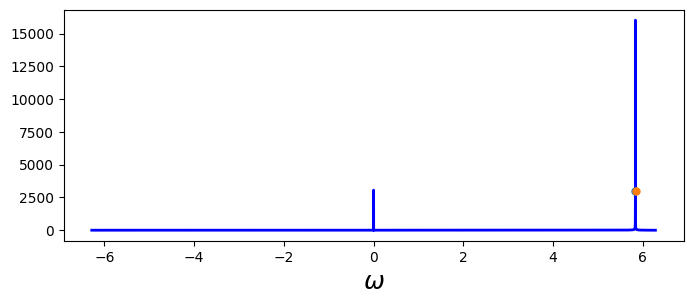

In [115]:
wr = (Ex_eign[1]-Ex_eign[0]) * (R/h)/1e9                      #nsolx = 15
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(w, abs(S),'b', linewidth=2)
ax.set_xlabel(r'$\omega$', fontsize=18)

plt.plot(wr, 3000, marker = "o", markersize = 5)
plt.plot(wr + 0.027, 3000, marker = "o", markersize = 5)    # B_y = 0.01
#plt.plot(wr + 0.095, 5000, marker = "o", markersize = 5)    # B_y = 0.07

#ax.set_xlim(wr-0.05, wr+0.05)

(5.772404593093202, 5.872404593093202)

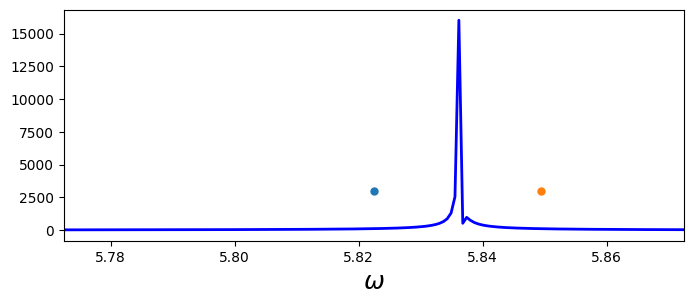

In [116]:
wr = (Ex_eign[1]-Ex_eign[0]) * (R/h)/1e9                      #nsolx = 8
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(w, abs(S),'b', linewidth=2)
ax.set_xlabel(r'$\omega$', fontsize=18)

plt.plot(wr, 3000, marker = "o", markersize = 5)
plt.plot(wr + 0.027, 3000, marker = "o", markersize = 5)    # B_y = 0.01
#plt.plot(wr + 0.095, 5000, marker = "o", markersize = 5)    # B_y = 0.07

ax.set_xlim(wr-0.05, wr+0.05)

(5.7864006888924475, 5.886400688892447)

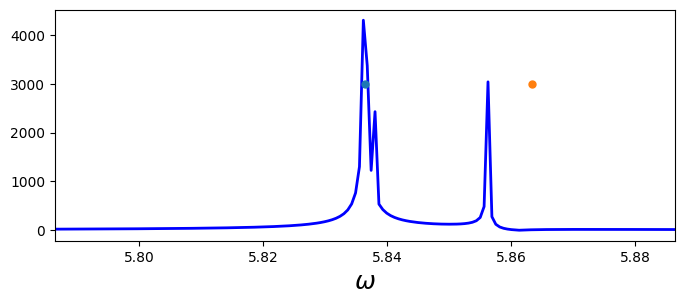

In [538]:
wr = (Ex_eign[1]-Ex_eign[0]) * (R/h)/1e9                      #nsolx = 6
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(w, abs(S),'b', linewidth=2)
ax.set_xlabel(r'$\omega$', fontsize=18)

plt.plot(wr, 3000, marker = "o", markersize = 5)
plt.plot(wr + 0.027, 3000, marker = "o", markersize = 5)    # B_y = 0.01
#plt.plot(wr + 0.095, 5000, marker = "o", markersize = 5)    # B_y = 0.07

ax.set_xlim(wr-0.05, wr+0.05)

In [90]:
B_y = linspace(0.0, 0.5, 50)

w_array = zeros((size(B_y),size(w)), dtype = float)
S_array = zeros((size(B_y),size(S)), dtype = float)

In [93]:
#By, Bz, Ez, nsolz, nz, az, nsolx, nx, ax, tlist, psi0
for i_ind, i_val in enumerate(B_y):
    w, S = Landau_split(i_val, 0.2085, 3.5*5*100, 2, 2000, 200, 25, 3000, 150, tlist, psi0)
    w_array[i_ind] = w
    S_array[i_ind] = S
    print('B_y = ', i_val)

B_y =  0.0
B_y =  0.01020408163265306
B_y =  0.02040816326530612
B_y =  0.030612244897959183
B_y =  0.04081632653061224
B_y =  0.0510204081632653
B_y =  0.061224489795918366
B_y =  0.07142857142857142
B_y =  0.08163265306122448
B_y =  0.09183673469387754
B_y =  0.1020408163265306
B_y =  0.11224489795918366
B_y =  0.12244897959183673
B_y =  0.13265306122448978
B_y =  0.14285714285714285
B_y =  0.1530612244897959
B_y =  0.16326530612244897
B_y =  0.17346938775510204
B_y =  0.18367346938775508
B_y =  0.19387755102040816
B_y =  0.2040816326530612
B_y =  0.21428571428571427
B_y =  0.22448979591836732
B_y =  0.2346938775510204
B_y =  0.24489795918367346
B_y =  0.25510204081632654
B_y =  0.26530612244897955
B_y =  0.2755102040816326
B_y =  0.2857142857142857
B_y =  0.29591836734693877
B_y =  0.3061224489795918
B_y =  0.31632653061224486
B_y =  0.32653061224489793
B_y =  0.336734693877551
B_y =  0.3469387755102041
B_y =  0.3571428571428571
B_y =  0.36734693877551017
B_y =  0.37755102040816324


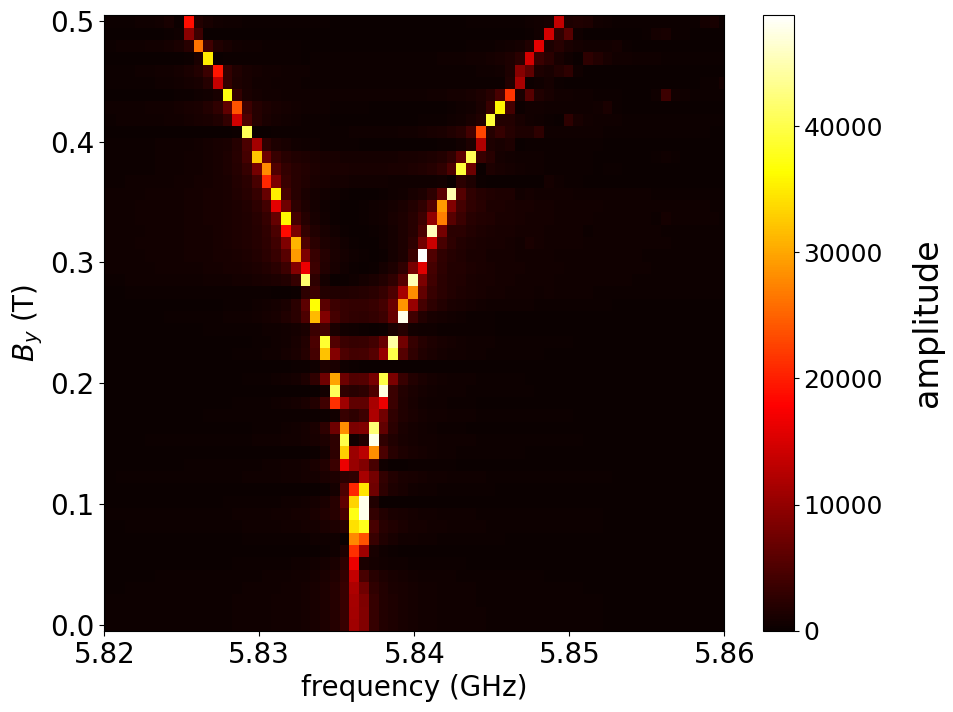

In [94]:
#hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize = (10, 8))
p = axes.pcolor(w, B_y, abs(S_array), cmap = cm.hot, shading='auto')
axes.tick_params(axis ='x', labelsize = 20)
axes.tick_params(axis ='y', labelsize = 20)
axes.set_xlabel(r'frequency (GHz)', fontsize=20)
axes.set_ylabel(r'$B_y$ (T)', fontsize = 20)
axes.set_xlim((5.82, 5.86))
#axes.set_ylim((0, 0.015))
cb = fig.colorbar(p, ax = axes)
cb.set_label(r'amplitude', labelpad = 20, rotation = 90, fontsize = 24)
cb.ax.tick_params(labelsize = 18)
#ymin, ymax = axes.get_ylim()
#axes.set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
#xmin, xmax = axes.get_xlim()
#axes.set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

#plt.plot(0.03575*6, 0.17, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
#plt.plot(0.03575*5.8, 0.03, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green")

plt.gcf().set_size_inches(10,8)
plt.savefig("C:/Users/Kirill/Desktop/splitting_vs_B_y_ to 0.5_He4_nsolx=25.png", bbox_inches="tight")

In [100]:
wr = (Ex_eign[1]-Ex_eign[0]) * (R/h/1e9)*2*pi                                                          # resonator frequency
wq = (Ez_eigh[1]-Ez_eigh[0]) * (R/h/1e9)*2*pi                                                          # qubit frequency
g  = 1.5*2*pi   

delta = wq - wr
Delta = wq + wr
lamb = g/delta
Lamb = g/Delta

chi = g**2/(wq - wr)
mu  = g**2/(wq + wr)

g_list = linspace(0, 5*2*pi, 100) 
shifts = g_list**2/(wq - wr) + g_list**2/(wq + wr)

Transformation coefficient B_y/g: 0.09


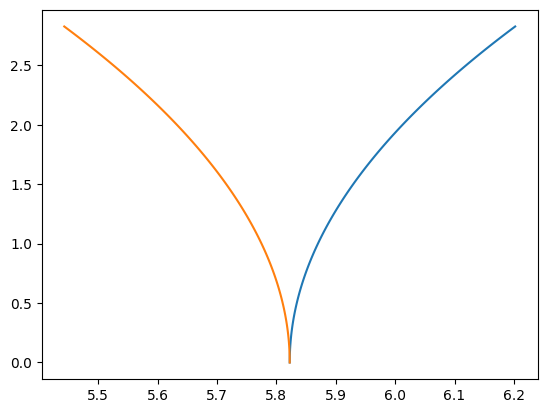

In [132]:
kof = 2.7/30
plt.plot((wr+shifts)/2/pi, g_list*kof)
plt.plot((wr-shifts)/2/pi, g_list*kof)
print('Transformation coefficient B_y/g:',round(kof,3))

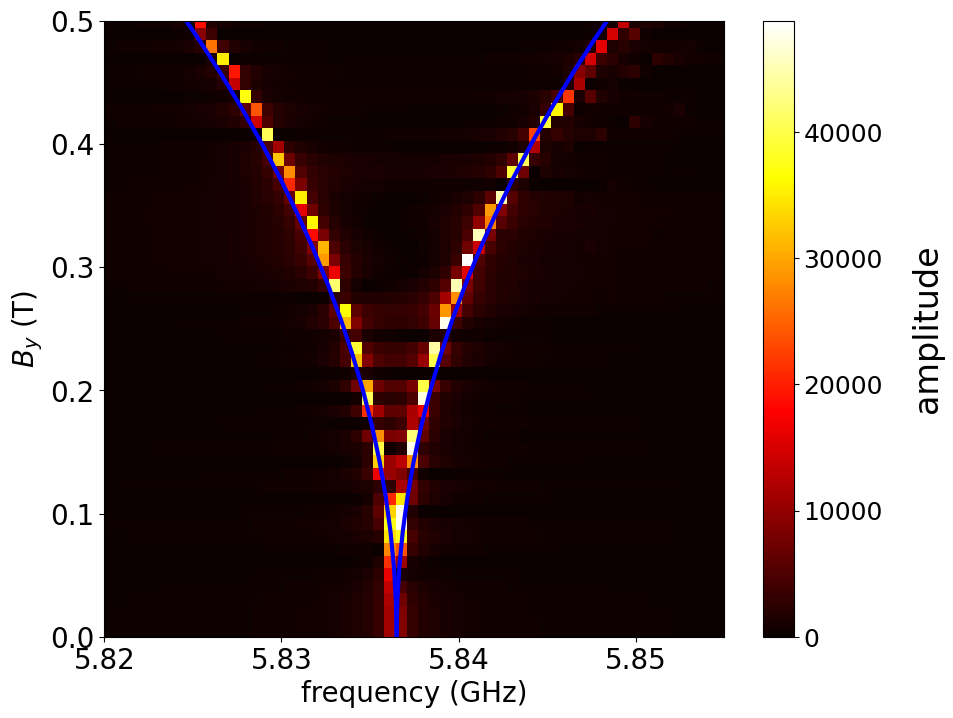

In [134]:
#hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize = (10, 8))
p = axes.pcolor(w, B_y, abs(S_array), cmap = cm.hot, shading='auto')

axes.tick_params(axis ='x', labelsize = 20)
axes.tick_params(axis ='y', labelsize = 20)
axes.set_xlabel(r'frequency (GHz)', fontsize=20)
axes.set_ylabel(r'$B_y$ (T)', fontsize = 20)
#axes.set_xlim((5.82, 5.86))
#axes.set_ylim((0, 0.015))
cb = fig.colorbar(p, ax = axes)
cb.set_label(r'amplitude', labelpad = 20, rotation = 90, fontsize = 24)
cb.ax.tick_params(labelsize = 18)

p = axes.plot((wr+shifts)/2/pi+0.0141, g_list*kof, 'b', linewidth=3.0)
p = axes.plot((wr-shifts)/2/pi+0.0141, g_list*kof, 'b', linewidth=3.0)

axes.set_xlim((5.82, 5.855))
axes.set_ylim((0, 0.5))

#ymin, ymax = axes.get_ylim()
#axes.set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
#xmin, xmax = axes.get_xlim()
#axes.set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

#plt.plot(0.03575*6, 0.17, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
#plt.plot(0.03575*5.8, 0.03, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green")

plt.gcf().set_size_inches(10,8)
plt.savefig("C:/Users/Kirill/Desktop/splitting_vs_B_y_ to 0.5_He4_nsolx=25_fitted_coeff=0.09.png", bbox_inches="tight")

In [527]:
B_y = linspace(-0.04, 0.04, 400)

w_array = zeros((size(B_y),size(w)), dtype = float)
S_array = zeros((size(B_y),size(S)), dtype = float)

In [528]:
for i_ind, i_val in enumerate(B_y):
    w, S = Landau_split(i_val, 0.2085, 3.5*5*100, 2, 2000, 200, 8, 2000, 100, tlist, psi0)
    w_array[i_ind] = w
    S_array[i_ind] = S
    print('B_y = ', i_val)

B_y =  -0.04
B_y =  -0.03979949874686717
B_y =  -0.039598997493734335
B_y =  -0.0393984962406015
B_y =  -0.03919799498746867
B_y =  -0.03899749373433584
B_y =  -0.03879699248120301
B_y =  -0.03859649122807018
B_y =  -0.038395989974937345
B_y =  -0.03819548872180451
B_y =  -0.03799498746867168
B_y =  -0.037794486215538846
B_y =  -0.03759398496240601
B_y =  -0.03739348370927319
B_y =  -0.037192982456140354
B_y =  -0.03699248120300752
B_y =  -0.03679197994987469
B_y =  -0.036591478696741855
B_y =  -0.03639097744360902
B_y =  -0.03619047619047619
B_y =  -0.03598997493734336
B_y =  -0.035789473684210524
B_y =  -0.0355889724310777
B_y =  -0.035388471177944865
B_y =  -0.03518796992481203
B_y =  -0.0349874686716792
B_y =  -0.034786967418546366
B_y =  -0.03458646616541353
B_y =  -0.0343859649122807
B_y =  -0.03418546365914787
B_y =  -0.033984962406015035
B_y =  -0.03378446115288221
B_y =  -0.033583959899749376
B_y =  -0.03338345864661654
B_y =  -0.03318295739348371
B_y =  -0.03298245614035088
B

B_y =  0.01774436090225564
B_y =  0.017944862155388472
B_y =  0.018145363408521305
B_y =  0.018345864661654138
B_y =  0.01854636591478697
B_y =  0.018746867167919803
B_y =  0.018947368421052636
B_y =  0.019147869674185462
B_y =  0.019348370927318295
B_y =  0.019548872180451128
B_y =  0.01974937343358396
B_y =  0.019949874686716794
B_y =  0.020150375939849627
B_y =  0.02035087719298246
B_y =  0.020551378446115293
B_y =  0.02075187969924812
B_y =  0.02095238095238095
B_y =  0.021152882205513784
B_y =  0.021353383458646617
B_y =  0.02155388471177945
B_y =  0.021754385964912283
B_y =  0.021954887218045116
B_y =  0.02215538847117795
B_y =  0.022355889724310782
B_y =  0.022556390977443615
B_y =  0.02275689223057644
B_y =  0.02295739348370928
B_y =  0.023157894736842106
B_y =  0.023358395989974932
B_y =  0.023558897243107772
B_y =  0.023759398496240598
B_y =  0.023959899749373438
B_y =  0.024160401002506264
B_y =  0.024360902255639104
B_y =  0.02456140350877193
B_y =  0.02476190476190477
B_y 

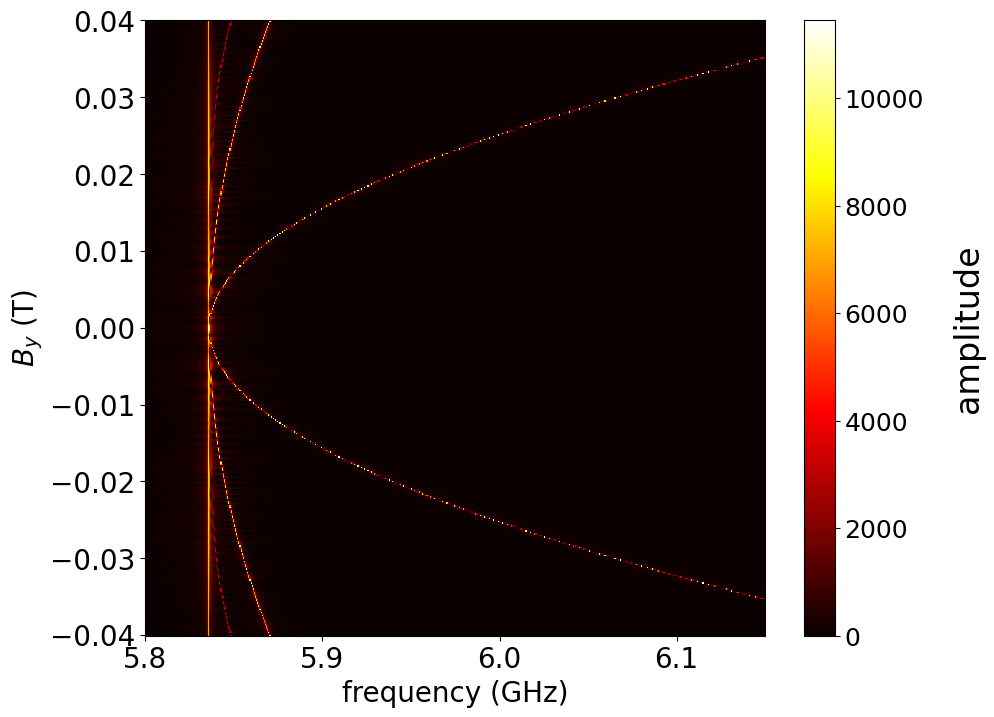

In [530]:
#hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize = (10, 8))
p = axes.pcolor(w, B_y, abs(S_array), cmap = cm.hot, shading='auto')
axes.tick_params(axis ='x', labelsize = 20)
axes.tick_params(axis ='y', labelsize = 20)
axes.set_xlabel(r'frequency (GHz)', fontsize=20)
axes.set_ylabel(r'$B_y$ (T)', fontsize = 20)
axes.set_xlim((5.80, 6.15))
#axes.set_ylim((0, 0.015))
cb = fig.colorbar(p, ax = axes)
cb.set_label(r'amplitude', labelpad = 20, rotation = 90, fontsize = 24)
cb.ax.tick_params(labelsize = 18)
#ymin, ymax = axes.get_ylim()
#axes.set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
#xmin, xmax = axes.get_xlim()
#axes.set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

#plt.plot(0.03575*6, 0.17, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
#plt.plot(0.03575*5.8, 0.03, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green")

plt.gcf().set_size_inches(10,8)
plt.savefig("C:/Users/Kirill/Desktop/splitting_vs_B_y_He4_big2.png", bbox_inches="tight")

# Correlation analysis

In [32]:
B_y = 0.5
B_z = 0.03572386754*12
chi = Dispersive_Landau(B_y, B_z, Electric_field)*2*np.pi
wr = qe/me * B_z / 10**9                                                          
wq = (eigenvalues_z[1]-eigenvalues_z[0]) * (Rydberg_Constant/h) * 2 * pi / 10**9      
print('Landau frequency:', wr/2/np.pi, 'GHz')
print('Rydberg frequency:', wq/2/np.pi, 'GHz')
delta = abs(wq - wr)
print('Detuning:', delta/2/np.pi, 'GHz')
g = np.sqrt(chi*delta)
print('Coupling constant:', g/2/np.pi, 'GHz')
print('Dispersive shift:', chi/2/np.pi*10**3, 'MHz')
Demo_rate = g**2/delta**2
print('Demolition rate:', Demo_rate*100, '%')
Crit_N = (delta/2/g)**2
print('Critical number of photons:', Crit_N)

Landau frequency: 12.000000003768204 GHz
Rydberg frequency: 118.66287725964892 GHz
Detuning: 106.66287725588072 GHz
Coupling constant: 10.326580391904315 GHz
Dispersive shift: 999.7692293134098 MHz
Demolition rate: 0.937316951346621 %
Critical number of photons: 26.671874400738297


# coupling strength 

In [578]:
me   = m_e                             # electron mass [kg] or 0.5109 [MeV]

R  = me * l4**2/(2 * hb**2)                         # the Rydberg constant for image charge in 4He
rB = hb**2/(l4 * me)                                # the effective Borh radius
wr = R/hb

In [673]:
By = 0.03                        # horizontal magnetic field B_y field [T]
Bz = 0.2085                      # vertical magnetic field B_z field [T]
wy = qe*By/me                    # fixed value of the \Omega_y
wc = qe*Bz/me                    # fixed value of the cyclotron frequency  

In [667]:
By = 0.2                         # horizontal magnetic field B_y field [T]
Bz = 1                           # vertical magnetic field B_z field [T]
wy = qe*By/me                    # fixed value of the \Omega_y
wc = qe*Bz/me                    # fixed value of the cyclotron frequency  

In [700]:
a    = tensor(destroy(nsolx), qeye(nsolz))                  # annihilation operator of the resonator
zop  = tensor(qeye(nsolx), Qobj(znm))                       # Z_{nm} operator

In [702]:
znm

array([[1.47379069, 0.59830539],
       [0.59830539, 5.17790297]])

In [675]:
#g    = sqrt(me*wc*(wy)**2/(2 * hb)) * rB /(2*pi*1e9)       # coupling constant in [GHz]

In [698]:
g    = sqrt(me*wc*wy**2/(2*hb))                               # coupling constant 
g/2/pi/1e9

10568611.47586162

In [694]:
g    = sqrt(wc*me/(2*hb))*wy*rB/wr                          # coupling constant 
g * (R/h)/1e9

0.08045620501515213

In [679]:
Hint = g * (a.dag() + a) * zop                              # interaction operator H_int in [GHz] units

In [680]:
Eint_eign, psi_int = linalg.eigh(Hint)                      # the eigenvalues and eigenvectors

In [681]:
Eint_eign

array([-1.69816359e-02, -1.38493088e-02, -1.11972117e-02, -8.77662753e-03,
       -6.49074400e-03, -4.44353619e-03, -4.28736468e-03, -3.62390910e-03,
       -2.92994241e-03, -2.29655507e-03, -2.13240572e-03, -1.69841445e-03,
       -1.12186248e-03, -5.57980517e-04, -8.33065805e-19, -2.45063789e-19,
        5.57980517e-04,  1.12186248e-03,  1.69841445e-03,  2.13240572e-03,
        2.29655507e-03,  2.92994241e-03,  3.62390910e-03,  4.28736468e-03,
        4.44353619e-03,  6.49074400e-03,  8.77662753e-03,  1.11972117e-02,
        1.38493088e-02,  1.69816359e-02])

In [684]:
Int = (Eint_eign[1]-Eint_eign[0]) * (R/h)/1e9
Int

0.49792184937583717

In [685]:
for i_id, i_value in enumerate(Eint_eign):
    print ((Eint_eign[i_id+1]-Eint_eign[i_id]) * (R/h/1e9))

0.49792184937583717
0.4215834081787967
0.3847815707676271
0.3633692537574067
0.3254288189667077
0.024825378065996818
0.1054644106306354
0.1103145267444595
0.10068469502295628
0.026093553991457175
0.06898824117429417
0.09165001571773622
0.08963596091866485
0.08869785430173434
9.347014033117964e-17
0.08869785430173423
0.08963596091866506
0.09165001571773622
0.06898824117429458
0.026093553991456898
0.10068469502295621
0.11031452674445943
0.10546441063063533
0.024825378065997095
0.32542881896670744
0.3633692537574063
0.38478157076762737
0.42158340817879614
0.49792184937583855


IndexError: index 30 is out of bounds for axis 0 with size 30

In [179]:
n_s

225000000000.0

In [178]:
n_s**(3/2)

1.067268710306828e+17

# Plasma frequency

In [200]:
n_s = 2.25*1e7   # [cm^-2]
n_s = 2.25*1e11  # [m^-2]

In [201]:
Omega_p = sqrt(2*pi*qe**2*n_s**(3/2)/me)*c

#Omega_p = sqrt(4*pi*n_s*qe**2/me)*c

In [202]:
print('Plasma frequency:', Omega_p/(2*pi)/10**9, 'GHz') 

Plasma frequency: 6558.938416997806 GHz


In [195]:
wc = qe*Bz/me
print('Landau frequency:', wc/(2*pi)/10**9, 'GHz')

Landau frequency: 5.822437893445271 GHz


In [194]:
print('Guiding centers frequency:', Omega_p**2/wc/(2*pi)/10**9, 'GHz')

Guiding centers frequency: 7388601.466475057 GHz


In [190]:
T = 0.120 

In [191]:
print('Thermal frequency:', kB*T/hbar/(2*pi)/10**9, 'GHz') 

Thermal frequency: 2.500394294799309 GHz


In [192]:
d = kB*T/me/(Omega_p)**2
print('Square displacement:', d*1e9, 'nm') 
print('Inter-electrom distance:', (n_s)**(-0.5)*1e9, 'nm') 

Square displacement: 1.0708994360827273e-12 nm
Inter-electrom distance: 2108.18510677892 nm


In [193]:
lB = sqrt(hb/(qe*Bz)) 

In [112]:
lB

5.625371598627041e-08